1.  https://www.kaggle.com/datasets/mujtabamatin/air-quality-and-pollution-assessment - выбранный датасет для рассмотрения

2. Немного обработаем наш датасет, выбросив из него все строчные значения, плюсом к этому добавим новый атрибут, чтобы понять, насколько масштабно вредит загрязненный воздух людям. Будем рассчитывать его в процентах: Humidity * 100 / Population_Density


In [4]:
import pandas as pd 
import matplotlib.pyplot as plt 
from feature_engine.outliers import OutlierTrimmer
import plotly.express as px
import seaborn as sb 
dframe = pd.read_csv('pollution_dataset.csv') # прочитаем датасет

print(dframe.head())

   Temperature  Humidity  PM2.5  PM10   NO2   SO2    CO  \
0         27.2      51.7   35.1  46.2  26.7  32.2  0.98   
1         26.3      59.3    1.0   6.2  38.3  20.4  0.68   
2         27.9      73.2   20.0  39.4  19.6   5.8  0.95   
3         23.9      51.9   14.7  24.3   5.2  12.6  1.24   
4         25.2      59.0   26.3  30.9  26.8  13.5  1.06   

   Proximity_to_Industrial_Areas  Population_Density Air Quality  
0                           11.2                 314   Hazardous  
1                           13.5                 298        Good  
2                            5.4                 309        Good  
3                            4.5                 282        Poor  
4                            5.6                 293        Poor  


Уберем колонку, которая будет мешать нам обрабатывать датасет

In [5]:
input_data = dframe.drop(dframe.columns[[-1]], axis=1)

print(input_data.head())

   Temperature  Humidity  PM2.5  PM10   NO2   SO2    CO  \
0         27.2      51.7   35.1  46.2  26.7  32.2  0.98   
1         26.3      59.3    1.0   6.2  38.3  20.4  0.68   
2         27.9      73.2   20.0  39.4  19.6   5.8  0.95   
3         23.9      51.9   14.7  24.3   5.2  12.6  1.24   
4         25.2      59.0   26.3  30.9  26.8  13.5  1.06   

   Proximity_to_Industrial_Areas  Population_Density  
0                           11.2                 314  
1                           13.5                 298  
2                            5.4                 309  
3                            4.5                 282  
4                            5.6                 293  


Добавим новый атрибут в датафрейм

In [6]:
input_data['Humidity at Population'] = input_data['Humidity'] * 100 / input_data['Population_Density']
print(input_data.head())

   Temperature  Humidity  PM2.5  PM10   NO2   SO2    CO  \
0         27.2      51.7   35.1  46.2  26.7  32.2  0.98   
1         26.3      59.3    1.0   6.2  38.3  20.4  0.68   
2         27.9      73.2   20.0  39.4  19.6   5.8  0.95   
3         23.9      51.9   14.7  24.3   5.2  12.6  1.24   
4         25.2      59.0   26.3  30.9  26.8  13.5  1.06   

   Proximity_to_Industrial_Areas  Population_Density  Humidity at Population  
0                           11.2                 314               16.464968  
1                           13.5                 298               19.899329  
2                            5.4                 309               23.689320  
3                            4.5                 282               18.404255  
4                            5.6                 293               20.136519  


Проверим датасет на пропуски

In [7]:
print(input_data.isnull().sum())

Temperature                      0
Humidity                         0
PM2.5                            0
PM10                             0
NO2                              0
SO2                              0
CO                               0
Proximity_to_Industrial_Areas    0
Population_Density               0
Humidity at Population           0
dtype: int64


Пропусков в датасете не нашли.
Теперь рассмотрим диаграммы на наличие выбросов

In [8]:
for feature in input_data.columns:
    fig=px.box(input_data,y=feature,title="<b>"+feature,boxmode="group", template="plotly_dark",points="all")
    fig.update_layout(title_x=0.5,title_font_size=30,font_size=15,font_color="aqua")
    fig.show()

Теперь обработаем выбросы в нашей модели, используя межквартильный размах

In [9]:
columns = input_data.describe().columns.tolist()
capper = OutlierTrimmer(capping_method='iqr', tail='both', fold=1.5, variables=columns)
dataCopy = input_data.copy()
capper.fit(dataCopy)

OutlierTrimmer(capping_method='iqr', fold=1.5, tail='both',
               variables=['Temperature', 'Humidity', 'PM2.5', 'PM10', 'NO2',
                          'SO2', 'CO', 'Proximity_to_Industrial_Areas',
                          'Population_Density', 'Humidity at Population'])

In [10]:
print(capper.right_tail_caps_)
print(capper.left_tail_caps_)

{'Temperature': 39.55, 'Humidity': 100.39999999999999, 'PM2.5': 91.0, 'PM10': 100.4, 'NO2': 48.05, 'SO2': 36.14999999999999, 'CO': 1.7000000000000002, 'Proximity_to_Industrial_Areas': 15.000000000000002, 'Population_Density': 345.5, 'Humidity at Population': 34.08225807177377}
{'Temperature': 11.150000000000004, 'Humidity': 19.600000000000005, 'PM2.5': -41.0, 'PM10': -30.000000000000007, 'NO2': -6.7499999999999964, 'SO2': -5.849999999999996, 'CO': 0.09999999999999976, 'Proximity_to_Industrial_Areas': -6.600000000000001, 'Population_Density': 253.5, 'Humidity at Population': 5.987155378646072}


Удалим выбросы с использованием границ, найденных через capper

In [11]:
dataCopy = capper.transform(dataCopy)

for feature in dataCopy.columns:
    fig=px.box(dataCopy,y=feature,title="<b>"+feature,boxmode="group", template="plotly_dark",points="all")
    fig.update_layout(title_x=0.5,title_font_size=30,font_size=15,font_color="aqua")
    fig.show()

Начнем кластеризацию, а количество кластеров определим ,используя метод локтя

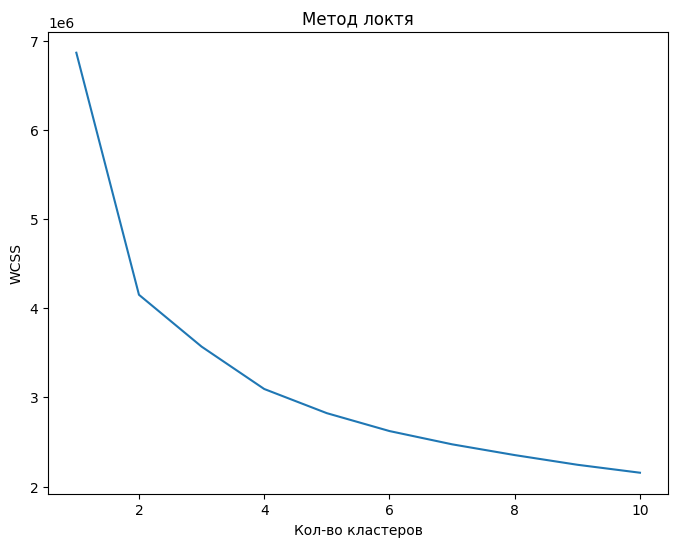

In [12]:
import matplotlib.pyplot as plt # импортируем библиотеку для графика.
from sklearn.cluster import KMeans # метод KMeans

X =dataCopy.values[:]
wcss = [] # wcss - within-cluster sum of squares, сумма квадратов внутрикластерных расстояний.
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300, n_init=12, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.subplots(figsize=(8, 6))
plt.plot(range(1,11), wcss)
plt.title('Метод локтя')
plt.xlabel('Кол-во кластеров')
plt.ylabel('WCSS')
plt.show()

In [13]:
clustersQuantity = 2 # рассмотрев график, видим, что имеем 2 главных кластера, их и возьмем
k_means = KMeans(init='k-means++', n_clusters=clustersQuantity, n_init=12)
k_means.fit(X)
labels = k_means.labels_
dataCopy['cluster'] = labels
print(dataCopy.head())

   Temperature  Humidity  PM2.5  PM10   NO2   SO2    CO  \
0         27.2      51.7   35.1  46.2  26.7  32.2  0.98   
1         26.3      59.3    1.0   6.2  38.3  20.4  0.68   
2         27.9      73.2   20.0  39.4  19.6   5.8  0.95   
3         23.9      51.9   14.7  24.3   5.2  12.6  1.24   
4         25.2      59.0   26.3  30.9  26.8  13.5  1.06   

   Proximity_to_Industrial_Areas  Population_Density  Humidity at Population  \
0                           11.2                 314               16.464968   
1                           13.5                 298               19.899329   
2                            5.4                 309               23.689320   
3                            4.5                 282               18.404255   
4                            5.6                 293               20.136519   

   cluster  
0        0  
1        1  
2        1  
3        1  
4        1  


Построим графики для нескольких зависимостей

Text(0, 0.5, 'CO')

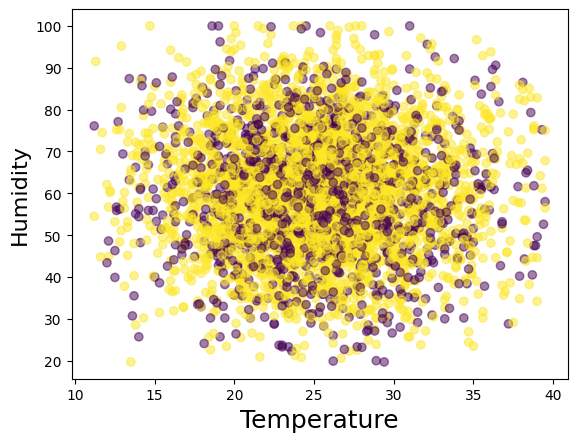

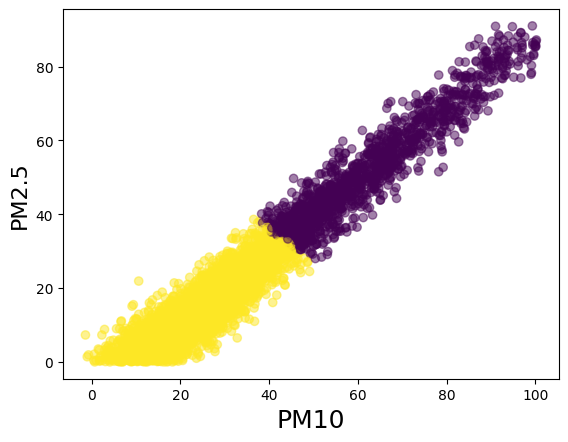

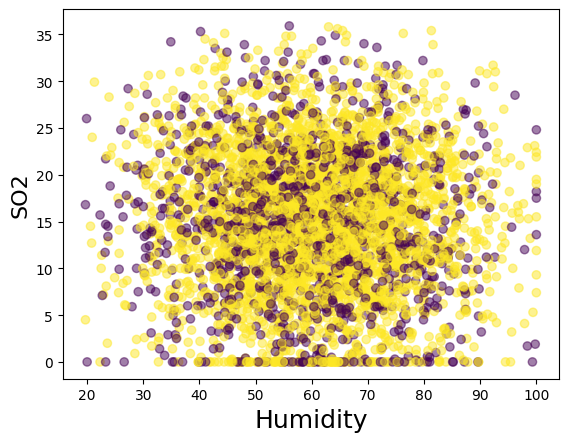

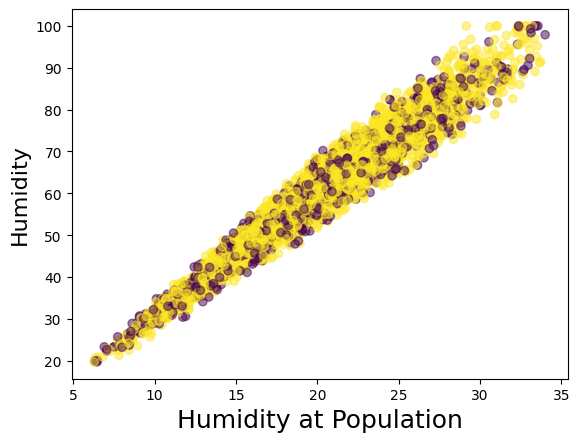

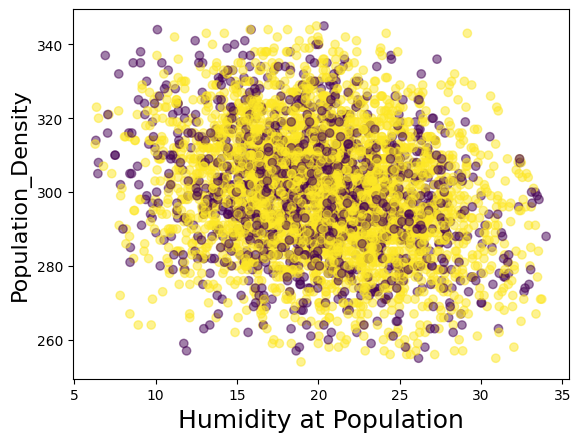

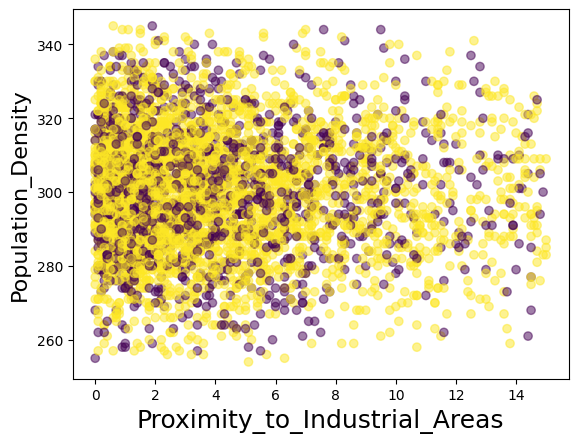

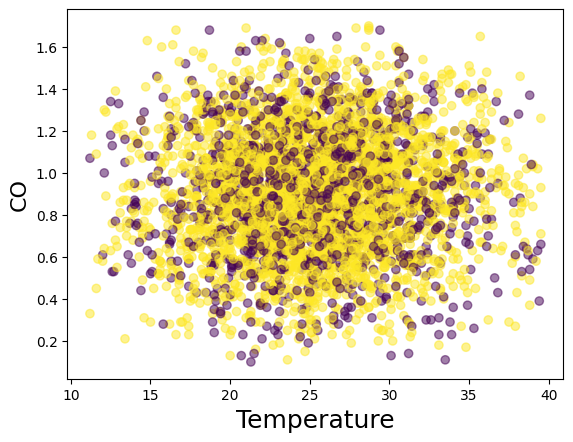

In [14]:
plt.figure()
plt.scatter(dataCopy['Temperature'], dataCopy['Humidity'], c=labels.astype(float), alpha=.5)
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('Humidity', fontsize=16)

plt.figure()
plt.scatter(dataCopy['PM10'], dataCopy['PM2.5'], c=labels.astype(float), alpha=.5)
plt.xlabel('PM10', fontsize=18)
plt.ylabel('PM2.5', fontsize=16)

plt.figure()
plt.scatter(dataCopy['Humidity'], dataCopy['SO2'], c=labels.astype(float), alpha=.5)
plt.xlabel('Humidity', fontsize=18)
plt.ylabel('SO2', fontsize=16)

plt.figure()
plt.scatter(dataCopy['Humidity at Population'], dataCopy['Humidity'], c=labels.astype(float), alpha=.5)
plt.xlabel('Humidity at Population', fontsize=18)
plt.ylabel('Humidity', fontsize=16)

plt.figure()
plt.scatter(dataCopy['Humidity at Population'], dataCopy['Population_Density'], c=labels.astype(float), alpha=.5)
plt.xlabel('Humidity at Population', fontsize=18)
plt.ylabel('Population_Density', fontsize=16)

plt.figure()
plt.scatter(dataCopy['Proximity_to_Industrial_Areas'], dataCopy['Population_Density'], c=labels.astype(float), alpha=.5)
plt.xlabel('Proximity_to_Industrial_Areas', fontsize=18)
plt.ylabel('Population_Density', fontsize=16)

plt.figure()
plt.scatter(dataCopy['Temperature'], dataCopy['CO'], c=labels.astype(float), alpha=.5)
plt.xlabel('Temperature', fontsize=18)
plt.ylabel('CO', fontsize=16)

Вывод: На построенных графиках видим, что наш датасет крайне плохо составил графики зависимостей. Это показывает то, что в нашем датасете практически нет зависимостей, и даже наша процентная характеристика, основанная на вреде определенному количеству населения, не показывает необходимого разделения, что показывает изначальную независимость взятых атрибутов друг от друга. При всем этом в датасете нашлась единственная зависимость от мелкодисперсной и крупнодисперсной пыли(PM2.5 / PM10), где видно четкий переход, при котором мелкодисперсная пыль становится крупнодисперсной, т.е меняет классификацию. В целом можно подвести итог, что наш датасет хоть и обладает довольно важными данными, но при этом эти данные изначально не имеют между собой связи, кроме тех, что изначально имеют одинаковое происхождение